In [1]:
import os
import time
from model.ResNet18 import ResNet18
from model.CustomCNN import CustomCNN
from model.MobileNetV2 import MobileNetV2

imagenet100_path = "data/imagenet-mini2"
# imagenet100_path = "data/imagenet-100-imagefolder"

ACTIVATIONS = ['ReLU', 'LeakyReLU', 'Sigmoid', 'Tanh', 'ELU', 'Swish_fixed', 'Swish_trainable']
MODELS = ['ResNet18', 'CustomCNN', 'MobileNetV2']

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models import densenet121, wide_resnet50_2
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2
from tqdm import tqdm
import time


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

train_dataset = datasets.ImageFolder(f"{imagenet100_path}/train", transform=train_transform)
val_dataset = datasets.ImageFolder(f"{imagenet100_path}/val", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)


In [4]:
# Define Activation Functions
class SwishFixed(nn.Module):
    def forward(self, x): return x * torch.sigmoid(x)

class SwishTrainable(nn.Module):
    def __init__(self):
        super().__init__()
        self.beta = nn.Parameter(torch.tensor(1.0))
        
    def forward(self, x): return x * torch.sigmoid(self.beta * x)

activation_map = {
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU(0.1),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'ELU': nn.ELU(),
    'Swish_fixed': SwishFixed(),
    'Swish_trainable': SwishTrainable()
}

# for name, act in activation_map.items():
#     print(f"{name}: {act}, type: {type(act)}, is nn.Module? {isinstance(act, nn.Module)}")


In [5]:
def validate(model, loader, criterion):
    model.eval(); total_loss=top1=top5=total=0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)

            _, pred = out.topk(5, dim=1)
            correct = pred.eq(y.view(-1, 1).expand_as(pred))
            top1 += correct[:, 0].sum().item()
            top5 += correct.sum().item()
            total += y.size(0)

    return total_loss / total, 100. * top1 / total, 100. * top5 / total


In [6]:
import torchvision.models as models
import torch.nn as nn

SELECT_MODEL = 'ResNet18'         # options: ResNet18, CustomCNN, MobileNetV2
SELECT_ACTIVATION = 'LeakyReLU'  # 'ReLU', 'LeakyReLU', 'Sigmoid', 'Tanh', 'ELU', 'Swish_fixed', 'Swish_trainable'
activation_fn = activation_map[SELECT_ACTIVATION]

num_classes = 20  # or 100 for ImageNet-100


In [ ]:
model = {
    'ResNet18': ResNet18(activation=activation_map[SELECT_ACTIVATION], num_classes=20),
    'CustomCNN': CustomCNN(activation=activation_map[SELECT_ACTIVATION], num_classes=20),
    'MobileNetV2': MobileNetV2(activation=activation_map[SELECT_ACTIVATION], num_classes=20)

}[SELECT_MODEL].to(device)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4, nesterov=True)
scheduler = CosineAnnealingLR(optimizer, T_max=200)

NUM_EPOCHS = 20
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_top5': [],
    'epoch_time': [],     # Track epoch duration (in seconds)
    'max_gpu_mem': []     # Track max GPU memory (in MB)
}

for epoch in range(1, NUM_EPOCHS+1):
    start_time = time.time()
    torch.cuda.reset_peak_memory_stats()  # Reset tracking
    
    model.train(); running_loss=correct=total=0; start=time.time()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}", unit='batch')
    for x,y in pbar:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad(); out = model(x); loss = criterion(out,y)
        loss.backward(); optimizer.step()
        bs = x.size(0); running_loss+=loss.item()*bs; preds=out.argmax(1)
        correct+=preds.eq(y).sum().item(); total+=bs
        elapsed = time.time()-start; rem=elapsed*(len(train_loader)-pbar.n)
        m, s = divmod(int(rem),60)
        pbar.set_postfix({'loss':f"{running_loss/total:.4f}",'acc':f"{100.*correct/total:.2f}%",'ETA':f"{m}m{s}s"})
    scheduler.step()
    
    epoch_time = time.time() - start_time
    max_mem_mb = torch.cuda.max_memory_allocated() / 1024 / 1024
    
    val_loss, val_top1, val_top5 = validate(model, val_loader, criterion)

    history['train_loss'].append(running_loss / total)
    history['train_acc'].append(100. * correct / total)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_top1)
    history.setdefault('val_top5', []).append(val_top5)
    history['epoch_time'].append(epoch_time)
    history['max_gpu_mem'].append(max_mem_mb)

    print(f"Epoch {epoch}/{NUM_EPOCHS} Train Acc: {100.*correct/total:.2f}% | "
          f"Val Top-1 Acc: {val_top1:.2f}% | Val Top-5 Acc: {val_top5:.2f}%")

# Save Model

save_dir = os.path.join("model", SELECT_ACTIVATION)
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, f"ImageNet100_{SELECT_MODEL}_{SELECT_ACTIVATION}.pth")
torch.save(model.state_dict(), save_path)

# save history
hist_dir = os.path.join("checkpoints", SELECT_ACTIVATION)
os.makedirs(hist_dir, exist_ok=True)

hist_path = os.path.join(hist_dir, f"history_{SELECT_MODEL}_{SELECT_ACTIVATION}.pt")
torch.save(history, hist_path)

print("Saved history to", hist_path)

Epoch 1/20: 100%|█| 24/24 [00:12<00:00,  1.96batch/s, loss=2.7232, acc


Epoch 1/20 Train Acc: 17.97% | Val Top-1 Acc: 15.60% | Val Top-5 Acc: 50.60%


Epoch 2/20: 100%|█| 24/24 [00:12<00:00,  1.97batch/s, loss=2.4938, acc


Epoch 2/20 Train Acc: 24.00% | Val Top-1 Acc: 19.70% | Val Top-5 Acc: 59.20%


Epoch 3/20: 100%|█| 24/24 [00:12<00:00,  1.94batch/s, loss=2.3339, acc


Epoch 3/20 Train Acc: 28.63% | Val Top-1 Acc: 28.20% | Val Top-5 Acc: 65.00%


Epoch 4/20: 100%|█| 24/24 [00:12<00:00,  1.89batch/s, loss=2.1883, acc


Epoch 4/20 Train Acc: 33.30% | Val Top-1 Acc: 30.70% | Val Top-5 Acc: 71.10%


Epoch 5/20: 100%|█| 24/24 [00:12<00:00,  1.96batch/s, loss=2.0638, acc


Epoch 5/20 Train Acc: 37.50% | Val Top-1 Acc: 27.60% | Val Top-5 Acc: 65.20%


Epoch 6/20: 100%|█| 24/24 [00:11<00:00,  2.01batch/s, loss=1.9579, acc


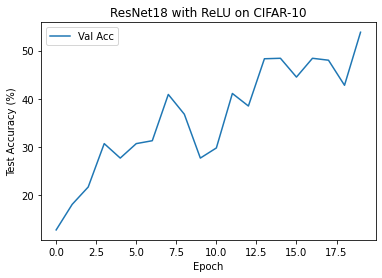

In [9]:
import matplotlib.pyplot as plt
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Test Accuracy (%)')
plt.title(f'{SELECT_MODEL} with {SELECT_ACTIVATION} on CIFAR-10')
plt.legend(); plt.show()


Missing: checkpoints/LeakyReLU/history_ResNet18_LeakyReLU.pt
Missing: checkpoints/Sigmoid/history_ResNet18_Sigmoid.pt
Missing: checkpoints/Tanh/history_ResNet18_Tanh.pt
Missing: checkpoints/ELU/history_ResNet18_ELU.pt
Missing: checkpoints/Swish_fixed/history_ResNet18_Swish_fixed.pt
Missing: checkpoints/Swish_trainable/history_ResNet18_Swish_trainable.pt


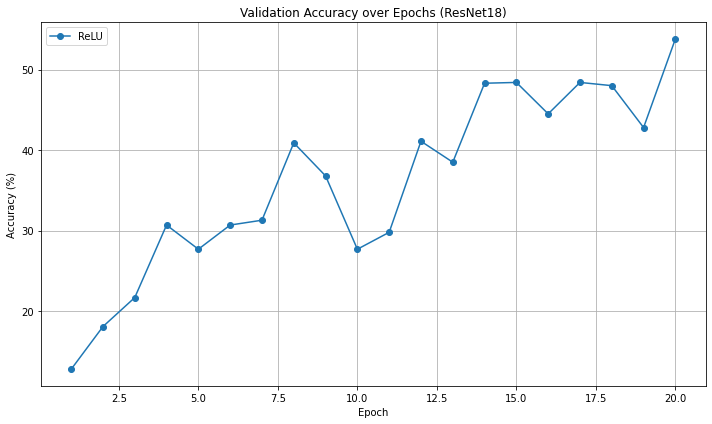

In [11]:
import os
import torch
import matplotlib.pyplot as plt

BASE_DIR = "checkpoints"  # or wherever your .pt files are saved
SELECT_MODEL = "ResNet18"  # or "ResNet18", etc.

# List all activations you used in training
ACTIVATIONS = ['ReLU', 'LeakyReLU', 'Sigmoid', 'Tanh', 'ELU', 'Swish_fixed', 'Swish_trainable']

plt.figure(figsize=(10,6))

for activation in ACTIVATIONS:
    hist_path = os.path.join(BASE_DIR, activation, f"history_{SELECT_MODEL}_{activation}.pt")
    if not os.path.exists(hist_path):
        print(f"Missing: {hist_path}")
        continue

    history = torch.load(hist_path)
    acc_list = history.get('val_acc', history.get('test_acc', []))
    
    if not acc_list:
        print(f"No val/test acc found in {activation}")
        continue

    epochs = range(1, len(acc_list) + 1)
    plt.plot(epochs, acc_list, marker='o', label=activation)

plt.title(f"Validation Accuracy over Epochs ({SELECT_MODEL})")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
